# Business need

In [1]:
### Hospitals want to segment patients into clinically meaningful groups to:
# Identify high-risk patient profiles
# Optimize treatment pathways
# Reduce readmissions
# Personalize care plans

# Import dataset

In [2]:
import numpy as np
import pandas as pd

np.random.seed(42)

n = 500

data = pd.DataFrame({
    "Age": np.random.randint(20, 85, n),
    "BMI": np.random.normal(27, 5, n),
    "SystolicBP": np.random.normal(130, 20, n),
    "DiastolicBP": np.random.normal(80, 12, n),
    "HeartRate": np.random.normal(72, 10, n),
    "Cholesterol": np.random.normal(200, 35, n),
    "Glucose": np.random.normal(110, 25, n),
    "HospitalVisits": np.random.poisson(2, n),
    "LengthOfStay": np.random.exponential(3, n),
    "ComorbidityCount": np.random.randint(0, 6, n)
})

data.head()


,Age,BMI,SystolicBP,DiastolicBP,HeartRate,Cholesterol,Glucose,HospitalVisits,LengthOfStay,ComorbidityCount
0,71,34.183773,126.380185,84.994836,77.768382,180.435185,146.538155,3,5.836766,1
1,34,23.491500,94.762725,92.914200,48.082783,211.902078,88.196158,2,5.096564,3
2,80,26.283584,128.619550,78.531837,59.331055,223.501821,160.590014,3,1.784505,2
3,40,23.996977,126.248427,74.778121,72.442594,223.149797,102.947499,2,2.015560,2
4,43,25.459110,132.503094,89.793409,67.957830,214.856558,79.547301,1,0.736738,3


# EDA

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

data.describe()


,Age,BMI,SystolicBP,DiastolicBP,HeartRate,Cholesterol,Glucose,HospitalVisits,LengthOfStay,ComorbidityCount
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,52.296000,27.336318,131.504965,80.136623,72.390015,202.802662,109.471967,1.926000,2.925780,2.504000
std,19.295518,5.403921,20.859564,11.263577,9.994008,35.852400,24.179170,1.411563,3.155486,1.750461
min,20.000000,13.076822,77.803164,39.780674,38.131862,103.362831,38.912868,0.000000,0.001883,0.000000
25%,36.000000,23.648573,117.768503,72.869310,65.491139,178.901427,91.984535,1.000000,0.716265,1.000000
50%,52.000000,27.279287,130.898360,80.340611,72.532180,204.732479,108.485482,2.000000,1.929133,3.000000
75%,70.000000,31.044404,146.427311,87.729079,79.119898,227.005747,127.235290,3.000000,3.921222,4.000000
max,84.000000,42.836858,192.097349,110.561999,106.958778,289.688468,177.108644,7.000000,26.399553,5.000000


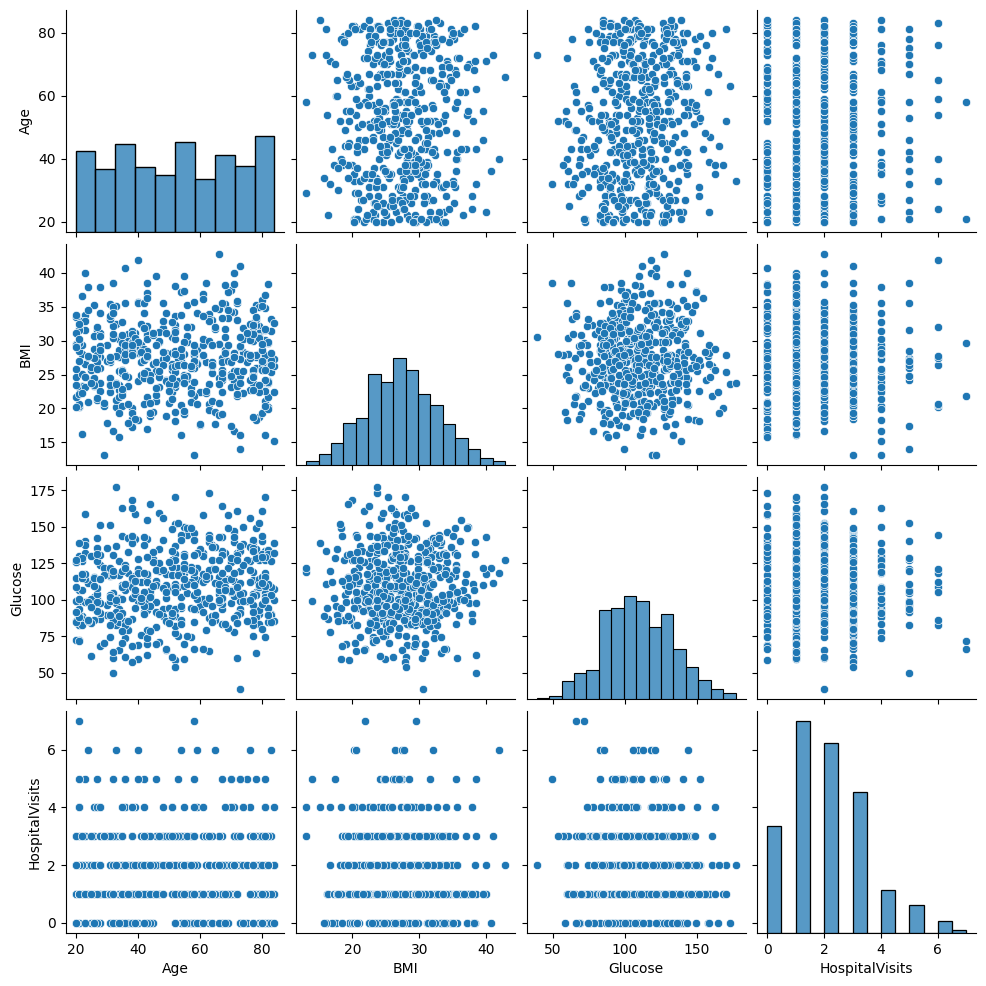

In [4]:
sns.pairplot(data[["Age", "BMI", "Glucose", "HospitalVisits"]])
plt.show()


# Data cleaning and processing

In [5]:
# Handle negative or unrealistic values
data["BMI"] = data["BMI"].clip(lower=15, upper=60)
data["Glucose"] = data["Glucose"].clip(lower=60)

In [6]:
# Check missing values
data.isnull().sum()

Age                 0
BMI                 0
SystolicBP          0
DiastolicBP         0
HeartRate           0
Cholesterol         0
Glucose             0
HospitalVisits      0
LengthOfStay        0
ComorbidityCount    0
dtype: int64

# Feature enginering

In [7]:
# Utilization intensity feature
data["UtilizationScore"] = (
    data["HospitalVisits"] * 0.6 +
    data["LengthOfStay"] * 0.4
)

In [8]:
# Risk index
data["MetabolicRisk"] = (
    data["BMI"] * 0.3 +
    data["Glucose"] * 0.4 +
    data["Cholesterol"] * 0.3
)

# Data Modeling Preparation

In [9]:
from sklearn.preprocessing import StandardScaler

features = data.select_dtypes(include=np.number)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


# Model Training

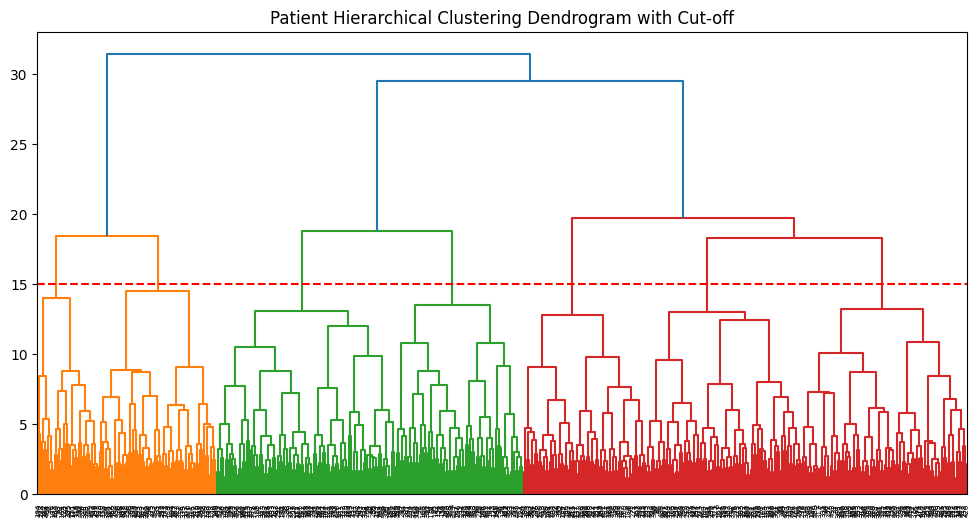

In [12]:
# model training with dendogram and add a line to indicate a cut-off
from scipy.cluster.hierarchy import dendrogram, linkage
linked = linkage(scaled_features, method="ward")
plt.figure(figsize=(12,6))
dendrogram(linked)
plt.axhline(y=15, color='r', linestyle='--')  # example cut-off line
plt.title("Patient Hierarchical Clustering Dendrogram with Cut-off")
plt.show()

# Model Evaluation 

In [13]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(
    n_clusters=4,
    metric="euclidean",
    linkage="ward"
)

data["Cluster"] = model.fit_predict(scaled_features)


In [14]:
data.groupby("Cluster").mean()
data["Cluster"].value_counts()

Cluster
2    173
0    165
1     96
3     66
Name: count, dtype: int64

# Model Tuning

In [16]:
for k in range(2, 7):
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(scaled_features)
    print(f"Clusters: {k}, Unique labels: {len(set(labels))}")
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
# silhouette score
sil_score = silhouette_score(scaled_features, data["Cluster"])
sil_score



Clusters: 2, Unique labels: 2
Clusters: 3, Unique labels: 3
Clusters: 4, Unique labels: 4
Clusters: 5, Unique labels: 5
Clusters: 6, Unique labels: 6


0.04522492070402914

# Model Interpretation and Validation

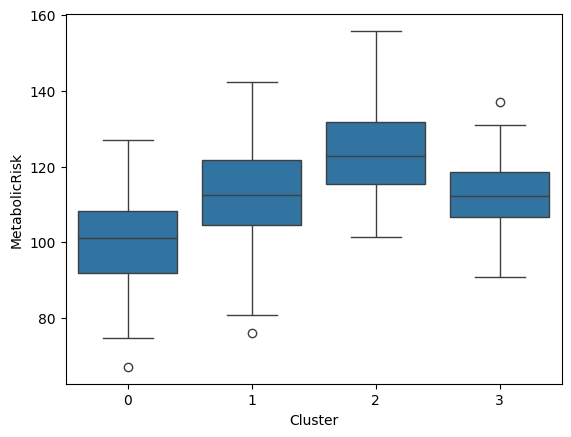

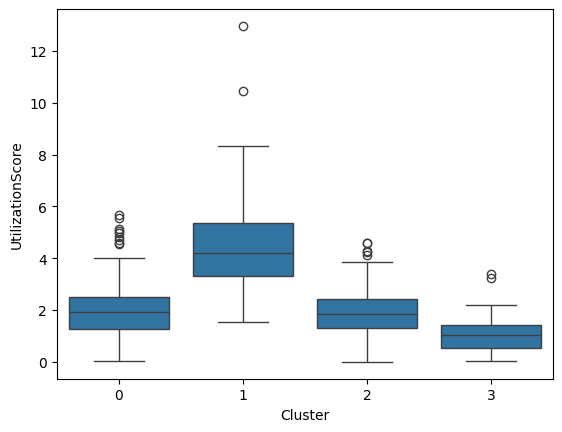

In [17]:
sns.boxplot(x="Cluster", y="MetabolicRisk", data=data)
plt.show()
sns.boxplot(x="Cluster", y="UtilizationScore", data=data)
plt.show()


# Model Deployment

In [18]:
import joblib

joblib.dump(model, "patient_clustering_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

# Model monitering and evaluation

In [19]:
# Monthly cluster size tracking
data["Cluster"].value_counts(normalize=True)

Cluster
2    0.346
0    0.330
1    0.192
3    0.132
Name: proportion, dtype: float64

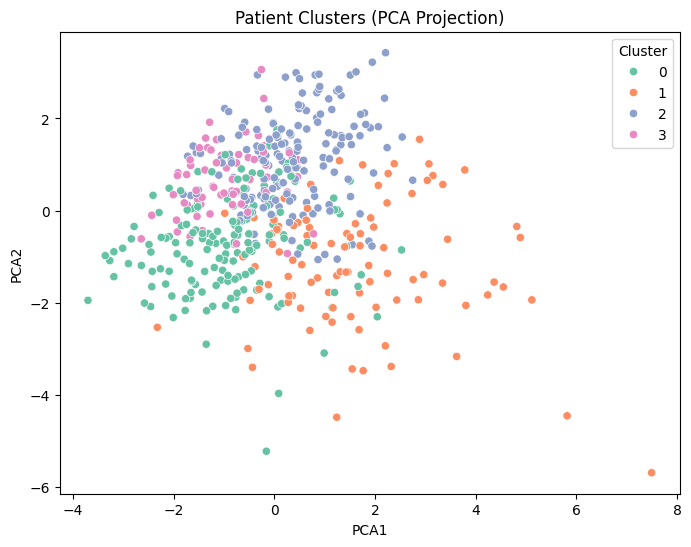

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

data["PCA1"] = pca_components[:, 0]
data["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="PCA1",
    y="PCA2",
    hue="Cluster",
    palette="Set2",
    data=data
)
plt.title("Patient Clusters (PCA Projection)")
plt.show()


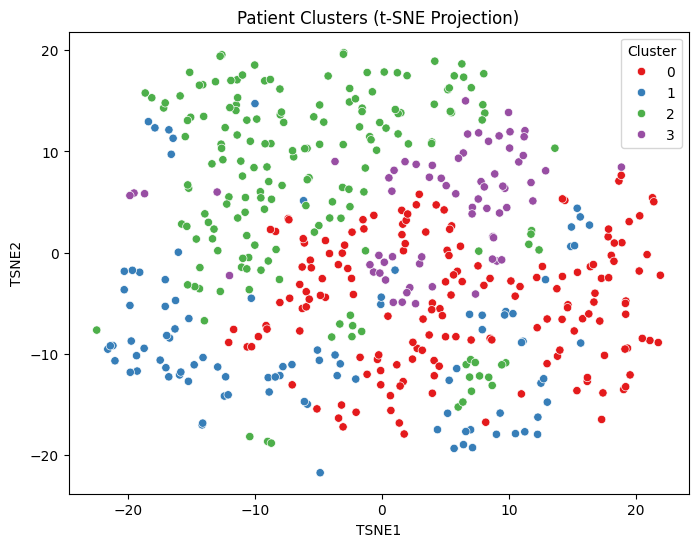

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42
)

tsne_components = tsne.fit_transform(scaled_features)

data["TSNE1"] = tsne_components[:, 0]
data["TSNE2"] = tsne_components[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="TSNE1",
    y="TSNE2",
    hue="Cluster",
    palette="Set1",
    data=data
)
plt.title("Patient Clusters (t-SNE Projection)")
plt.show()
